# Deep Learning image search

**Motores de busca de imagens:**
Em termos gerais, um motor de busca normalmente recebe uma consulta e retorna resultados. Os motores de busca de imagens recebem uma imagem de entrada como uma consulta de imagem e, em seguida, o motor de busca de imagens encontra imagens "similares" dentro do seu banco de dados indexado e as retorna como resultado da pesquisa.

**Como medir a similaridade entre duas imagens?**   
- 1- **Espaço de Pixels**: Uma maneira simples é medir a distância euclidiana entre as duas imagens no espaço de pixels. Portanto, se duas imagens têm valores comuns ou próximos para os pixels correspondentes, são consideradas "similares". Isso pode funcionar às vezes, no entanto, imagens de golfinhos e aviões com fundos azuis seriam consideradas semelhantes do ponto de vista dos pixels, e não é isos que queremos!

- 2- **Espaço de Características**: Outra abordagem é usar o espaço de características em vez do espaço de pixels ao calcular a distância euclidiana entre as duas imagens. Em outras palavras, projeta-se as imagens em um espaço onde imagens com características semelhantes estão próximas umas das outras. Nesse espaço, golfinhos e aviões são separados, apesar da similaridade a nível de pixel.      

**Como obter características de imagens?**  
Agora a pergunta é: como projetar uma imagem arbitrária em um espaço onde imagens similares, com base em seu conteúdo complexo, são agrupadas? Bem, a resposta é fácil! Basta usar uma rede pré-treinada, como o InceptionV3 treinado no ImageNet Large Scale Visual Recognition Challenge (ILSVRC). A rede é treinada para classificar uma imagem de entrada em uma das 1000 classes diferentes. Portanto, se alimentarmos a rede com imagens arbitrárias e, antes da saída, podemos obter um vetor de características forte que resume o conteúdo das imagens de entrada          

Para o motor de busca de imagens, vamos usar o vetor de características gerado por uma rede pré-treinada (como o InceptionV3, por exemplo), em vez da abordagem ingênua baseada em pixels.       

**Dataset:**   
Nos exemplos seguintes, usamos o conjunto de dados Caltech 101. Para simplicidade, foram usadas apenas 9 classes: 

`['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']`


**Passos de Implementação:**   
1. Baixar os dados e convertê-los em X (imagens) e y (rótulos)
2. Aleatorizar os dados e selecionar um subconjunto dos dados como o conjunto de dados no qual desejamos realizar a pesquisa.
3. Carregar a rede InceptionV3 com pesos e sem a parte superior para obter as características de alto nível.
4. Calcular a característica para todas as imagens no conjunto de dados.
5. Para uma imagem de consulta: calcular seu vetor de características. Fazer um loop e encontrar a distância euclidiana entre as características da imagem de consulta e as características do conjunto de dados. Retornar os resultados mais próximos.       

Obs.: Se o conjunto de dados for muito grande, métodos mais otimizados podem ser usados para encontrar os candidatos mais próximos à imagem de consulta, como KDTree e BallTree.


In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import os
import cv2
import operator

In [2]:
model = InceptionV3(weights='imagenet', include_top=False)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [3]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

# Caltech 101

Link do dataset: https://www.kaggle.com/datasets/imbikramsaha/caltech-101/

In [4]:
data_directory = "../data"
categories = os.listdir(data_directory + "/101_ObjectCategories/")
object_images_count_dict = {}
for category in categories:
    object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
print(object_images_count_dict)

[('airplanes', 800), ('Motorbikes', 798), ('BACKGROUND_Google', 468), ('Faces', 435), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107), ('hawksbill', 100), ('grand_piano', 99), ('brain', 98), ('butterfly', 91), ('helicopter', 88), ('menorah', 87), ('kangaroo', 86), ('starfish', 86), ('trilobite', 86), ('buddha', 85), ('ewer', 85), ('sunflower', 85), ('scorpion', 84), ('revolver', 82), ('laptop', 81), ('ibis', 80), ('llama', 78), ('minaret', 76), ('electric_guitar', 75), ('umbrella', 75), ('crab', 73), ('crayfish', 70), ('cougar_face', 69), ('dragonfly', 68), ('dalmatian', 67), ('ferry', 67), ('flamingo', 67), ('lotus', 66), ('dolphin', 65), ('elephant', 64), ('euphonium', 64), ('joshua_tree', 64), ('soccer_ball', 64), ('stop_sign', 64), ('schooner', 63), ('chair', 62), ('lamp', 61), ('yin_yang', 60), ('cellphone', 59), ('rhino', 59), ('stegosaurus', 59), ('wheelchair', 59), ('cup', 57), ('pyramid', 57), ('se

In [5]:
len(object_images_count_dict)

102

In [6]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data not found!")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correct colors
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [7]:
i = 0
X = np.ndarray((10000, 200, 300, 3), dtype=np.uint8)
Y = []

selected_cls = ['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'Leopards', 'car_side', 'grand_piano', 'brain', 'butterfly']

for category,_ in object_images_count_dict:
    if category in selected_cls:
      for image in get_images(category, data_directory):
          if not image.endswith('.jpg'):
              continue
          X[i] = read_image(image)
          Y.insert(i,category) 
          i += 1
      print(str(i+1) + "  " + category)


X = X[:i]
print("Done")


801  airplanes
1599  Motorbikes
2034  Faces
2469  Faces_easy
2669  Leopards
2792  car_side
2891  grand_piano
2989  brain
3080  butterfly
Done


In [8]:
X.shape

(3079, 200, 300, 3)

In [9]:
Y[0]

'airplanes'

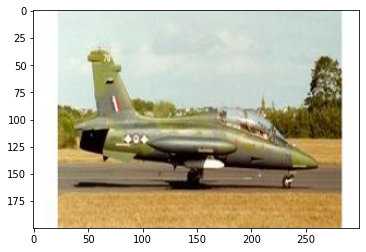

In [10]:
plt.imshow(X[0])

In [11]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([4, 4, 4, ..., 6, 6, 6], dtype=int64)

In [12]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [13]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['airplanes'], dtype='<U11')

In [14]:
# randomize and select sample data
x_train, x_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.3, random_state=42)

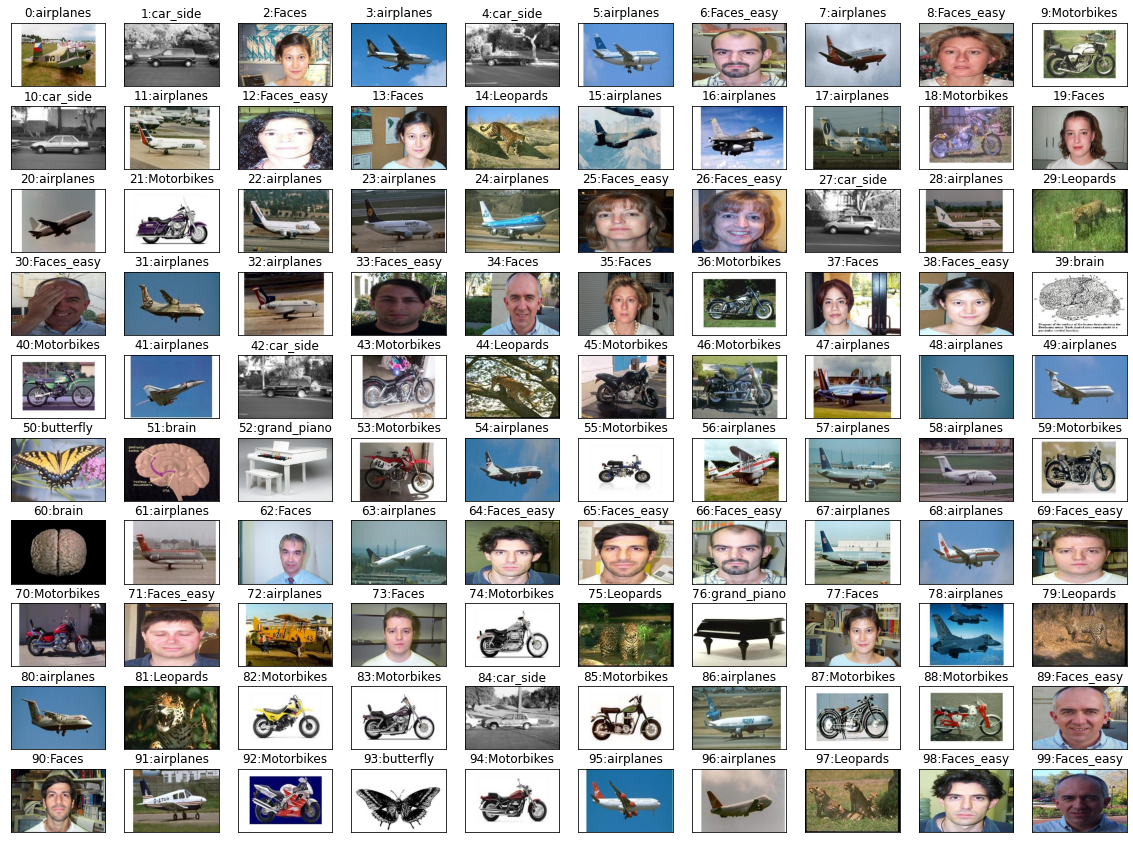

In [15]:
fig=plt.figure(figsize=(20, 15))
columns = 10
rows = 10
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[i])
    t = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    plt.title(str(i) +":"+ t)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
for i in range(len(selected_cls)):
  print(i , label_encoder.inverse_transform([i])[0])

0 Faces
1 Faces_easy
2 Leopards
3 Motorbikes
4 airplanes
5 brain
6 butterfly
7 car_side
8 grand_piano


In [17]:
data_set = preprocess_input(x_test)

In [18]:
feats = model.predict(data_set)
feats = np.squeeze(feats)
print(feats.shape)

29/29 [==============================] - 97s 2s/step
(924, 4, 8, 2048)


1/1 [==============================] - 0s 173ms/step


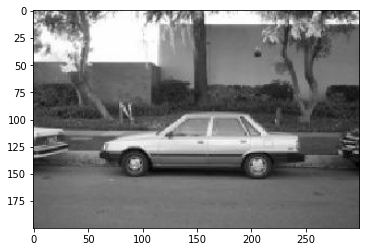

In [19]:
Q_id = 10
Query_image = x_test[Q_id]
plt.imshow(Query_image)
Query_image = preprocess_input(Query_image)
Query_feats = model.predict(np.expand_dims(Query_image, axis=0))
Query_feats = Query_feats.squeeze()

In [20]:
# Euclidean distance
results = []
for i in range(feats.shape[0]):
  d = np.linalg.norm(feats[i].flatten() - Query_feats.flatten())
  results.append((d, i))

results = sorted(results)

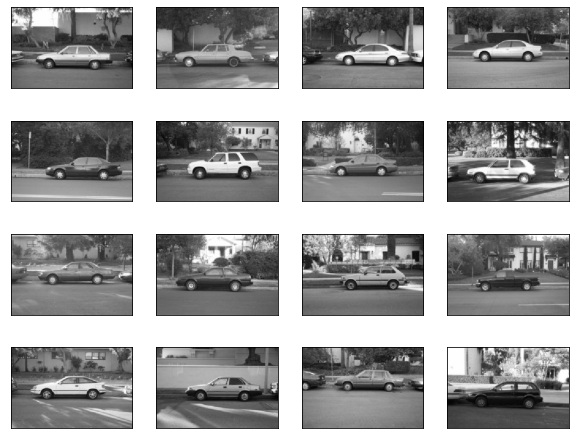

In [21]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
# Euclidean distance
results = []
for i in range(x_test.shape[0]):
  d = np.linalg.norm(x_test[i].flatten() - x_test[Q_id].flatten())
  results.append((d, i))

results = sorted(results)

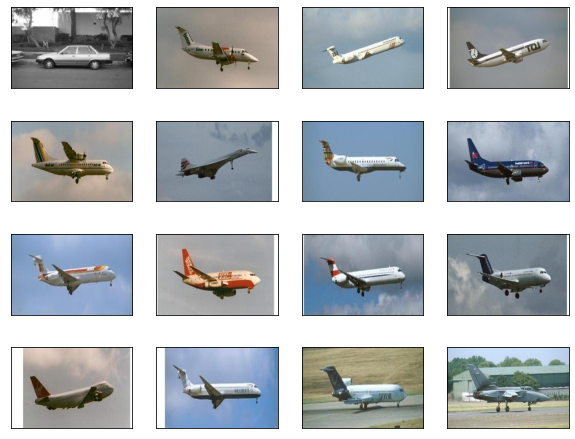

In [23]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
# http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
def plot_dataset(X, y, X_embedded, min_dist=10.0):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(frameon=False)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
    
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            res = cv2.resize(X[i], dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(res), X_embedded[i])
            ax.add_artist(imagebox)

In [25]:
n_tsne = 300

In [26]:
tsne_feats = np.reshape(feats, (feats.shape[0], feats.shape[1]*feats.shape[2]*feats.shape[3]))[:n_tsne]
tsne_f = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_feats)
print(tsne_f.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.024s...
[t-SNE] Computed neighbors for 300 samples in 3.713s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 63.439194
[t-SNE] Computed conditional probabilities in 0.052s
[t-SNE] Iteration 50: error = 54.7515602, gradient norm = 0.2525525 (50 iterations in 0.108s)
[t-SNE] Iteration 100: error = 54.6299171, gradient norm = 0.2235377 (50 iterations in 0.097s)
[t-SNE] Iteration 150: error = 55.7448196, gradient norm = 0.3742564 (50 iterations in 0.079s)
[t-SNE] Iteration 200: error = 55.3549728, gradient norm = 0.2322000 (50 iterations in 0.097s)
[t-SNE] Iteration 250: error = 56.2213020, gradient norm = 0.1719476 (50 iterations in 0.214s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.221302
[t-SNE] Iteration 300: error = 0.4804065, gradient norm = 0.0051918 (50 iterations in 0.203s)
[t-SNE] Iteration 350: error = 0.4551856, gradient norm = 0.0034636 

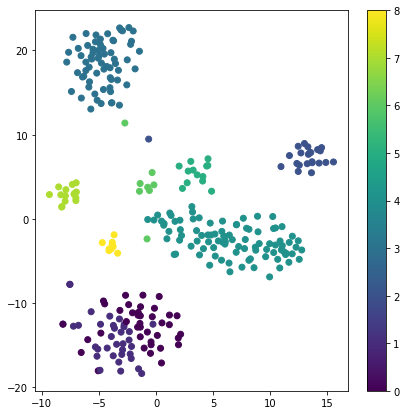

In [27]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], c=c)

plt.colorbar()
plt.show()

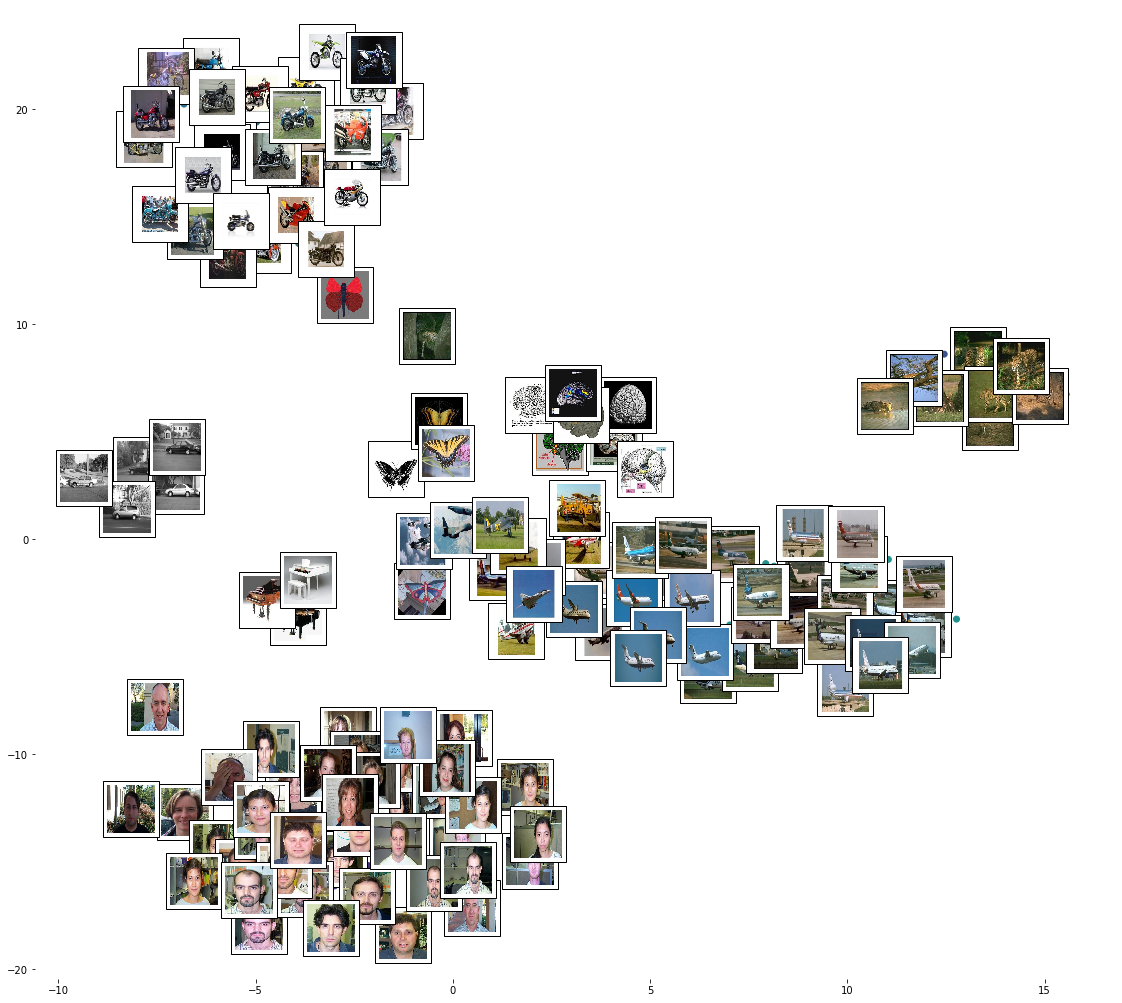

In [28]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_f[:n_tsne], min_dist=1.0)

In [29]:
tsne_pix = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))[:n_tsne]
tsne_p = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_pix)   
print(tsne_p.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.047s...
[t-SNE] Computed neighbors for 300 samples in 4.006s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 11335.210623
[t-SNE] Computed conditional probabilities in 0.062s
[t-SNE] Iteration 50: error = 57.4150314, gradient norm = 0.1528571 (50 iterations in 0.141s)
[t-SNE] Iteration 100: error = 57.7645645, gradient norm = 0.1592553 (50 iterations in 0.078s)
[t-SNE] Iteration 150: error = 58.5140381, gradient norm = 0.1978126 (50 iterations in 0.094s)
[t-SNE] Iteration 200: error = 60.3628693, gradient norm = 0.1826556 (50 iterations in 0.109s)
[t-SNE] Iteration 250: error = 59.4076920, gradient norm = 0.2001838 (50 iterations in 0.094s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.407692
[t-SNE] Iteration 300: error = 0.6883891, gradient norm = 0.0053882 (50 iterations in 0.063s)
[t-SNE] Iteration 350: error = 0.6645482, gradient norm = 0.00272

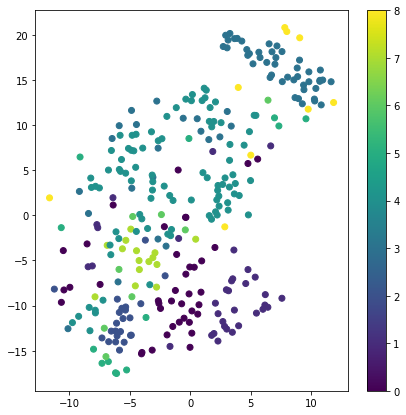

In [30]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_p[:, 0], tsne_p[:, 1], c=c)

plt.colorbar()
plt.show()

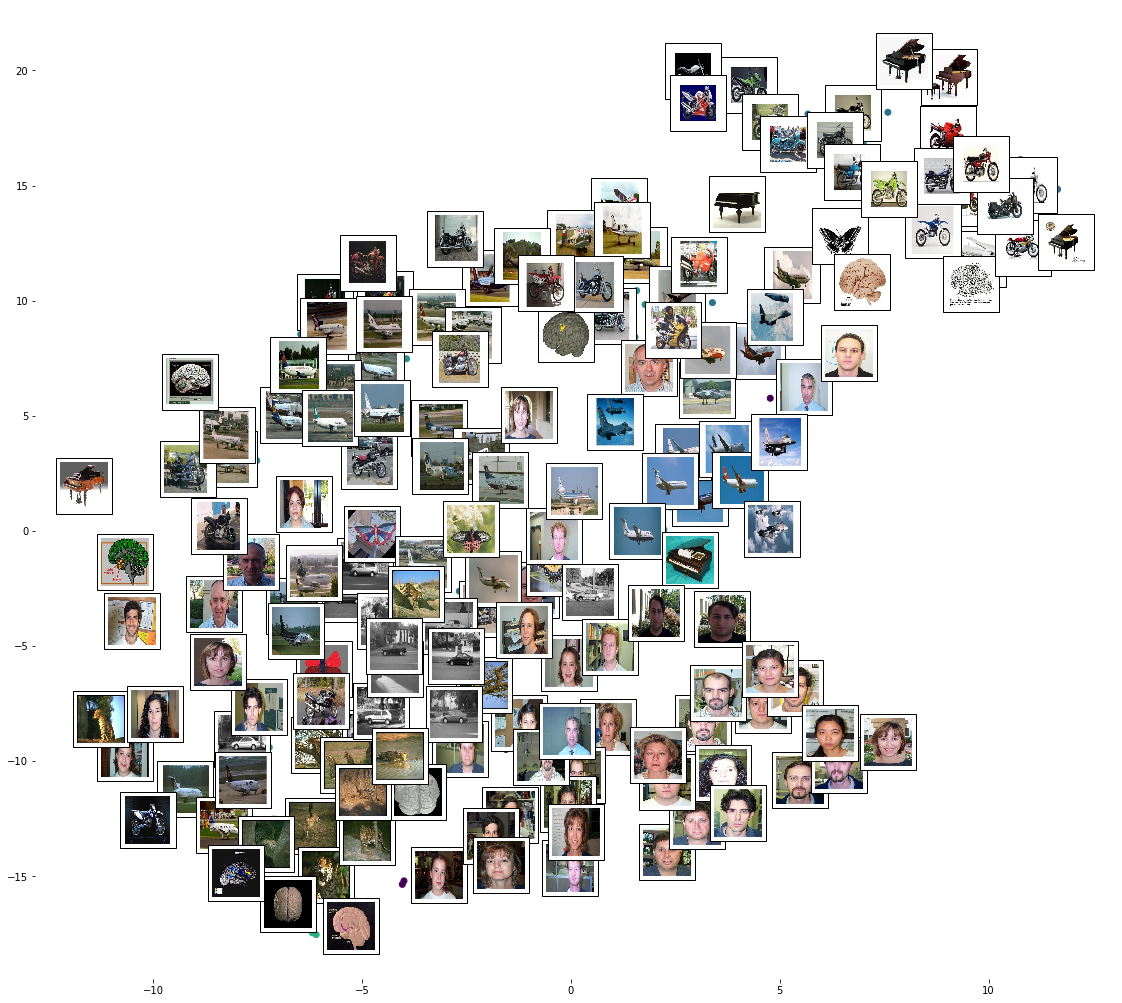

In [31]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_p[:n_tsne], min_dist=1.0)